In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

In [2]:
from yellowbrick.classifier import DiscriminationThreshold

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [3]:
data = pd.read_csv('Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Сначала подготовим датасет

In [14]:
Id_col = ['customerID']
target = ['Churn']
cat_cols = [x for x in data.columns.tolist() if data.nunique()[x] < 6 and x not in Id_col+target]
num_cols = [x for x in data.columns.tolist() if x not in cat_cols+Id_col+target]

In [17]:
bin_cols = [x for x in cat_cols if data.nunique()[x] == 2]
multi_cols = [x for x in cat_cols if x not in bin_cols]
encoder = LabelEncoder()
bin_features = data[bin_cols]

for i in bin_cols:
    bin_features[i] = encoder.fit_transform(bin_features[i])
    
multi_features = data[multi_cols]
multi_features = pd.get_dummies(multi_features)

cat_features = bin_features.merge(multi_features, left_index=True, right_index=True, how='left')

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [38]:
data['TotalCharges'].replace(' ', '0', inplace=True)
data['TotalCharges'].astype(float)

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

Добавим несколько новых фичей.

In [44]:
scaler = StandardScaler()
num_features = data[num_cols]

scaled_num_features = scaler.fit_transform(num_features)

scaled_num_features = pd.DataFrame(scaled_num_features, columns=num_cols)
X = scaled_num_features.merge(cat_features, left_index=True, right_index=True, how='left')

tsne_ = TSNE(n_components=2, random_state=42)
X_tsne = tsne_.fit_transform(X)

cluster = DBSCAN(eps=3, leaf_size=15)
X_clusters = cluster.fit_predict(X_tsne)

pca_ = PCA(n_components=2, svd_solver='full')
X_pca = pca_.fit_transform(X)
X['cluster'] = X_clusters
X['pca1'] = X_pca[:, 0]
X['pca2'] = X_pca[:, 1]

In [47]:
Y = data[target].replace({'Yes': 1, 'No': 0})

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [50]:
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

Теперь попробуем построить модель

In [51]:
from sklearn.model_selection import RandomizedSearchCV

In [129]:
model = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate': [0.1, 0.01, 0.005, 0.001], 'n_estimators': [100, 300, 500, 1000], 'max_depth': [3, 5, 9, 12],
             'max_features': [None, 'sqrt']}

search = RandomizedSearchCV(model, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_train, y_train.values.ravel())
search.best_score_, search.best_params_

(0.5760749325991534,
 {'n_estimators': 100,
  'max_features': 'sqrt',
  'max_depth': 3,
  'learning_rate': 0.1})

In [130]:
GBclassifier_base = GradientBoostingClassifier(**search.best_params_, random_state=42)

In [70]:
cols = [x for x in X.columns if x not in Id_col+target]

In [73]:
import warnings
warnings.filterwarnings('ignore')

GradientBoostingClassifier(max_features='sqrt', random_state=42)

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1282
           1       0.68      0.52      0.59       479

    accuracy                           0.80      1761
   macro avg       0.76      0.71      0.73      1761
weighted avg       0.79      0.80      0.79      1761

Accuracy   Score :  0.8029528676888131
Area under curve :  0.7142846674200997 



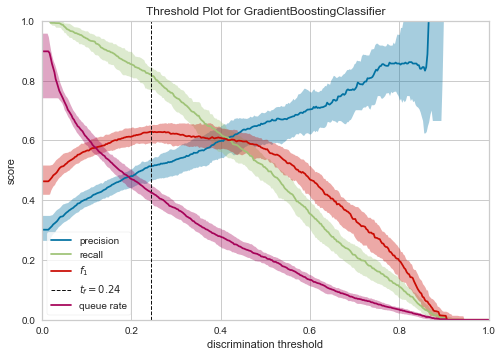

In [131]:
telecom_churn_prediction(GBclassifier_base, X_train, X_test, y_train.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = True)

Теперь сделаем oversampling чтобы сбалансировать датасет по классам и вновь построим модель.

In [75]:
from imblearn.over_sampling import SMOTE

In [78]:
os = SMOTE(random_state=42)
X_train_os, y_train_os = os.fit_sample(X_train, y_train)

In [80]:
model = GradientBoostingClassifier(random_state=42)
search = RandomizedSearchCV(model, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_train_os, y_train_os.values.ravel())
search.best_score_, search.best_params_

(0.8584827328829192,
 {'n_estimators': 1000,
  'max_features': 'sqrt',
  'max_depth': 12,
  'learning_rate': 0.1})

In [81]:
GBclassifier = GradientBoostingClassifier(**search.best_params_, random_state=42)

In [84]:
telecom_churn_prediction(GBclassifier, X_train_os, X_test, y_train_os.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = False)

GradientBoostingClassifier(max_depth=12, max_features='sqrt', n_estimators=1000,
                           random_state=42)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1282
           1       0.57      0.54      0.56       479

    accuracy                           0.77      1761
   macro avg       0.70      0.70      0.70      1761
weighted avg       0.76      0.77      0.76      1761

Accuracy   Score :  0.7654741624077229
Area under curve :  0.6957357208693359 



Попробуем еще несколько моделей.

In [85]:
from lightgbm import LGBMClassifier

In [86]:
param_grid = {'learning_rate': [0.1, 0.01, 0.005, 0.001], 'n_estimators': [100, 300, 500, 1000], 'max_depth': [-1, 3, 5, 9, 12]}

In [87]:
lightgbm_ = LGBMClassifier()

In [89]:
search = RandomizedSearchCV(lightgbm_, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_train_os, y_train_os.values.ravel())
search.best_score_, search.best_params_

(0.8338797902067133,
 {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.01})

In [90]:
lightgbm_ = LGBMClassifier(**search.best_params_)

LGBMClassifier(learning_rate=0.01, max_depth=12, n_estimators=1000)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1282
           1       0.59      0.68      0.63       479

    accuracy                           0.78      1761
   macro avg       0.73      0.75      0.74      1761
weighted avg       0.80      0.78      0.79      1761

Accuracy   Score :  0.7847813742191937
Area under curve :  0.7508410983620973 



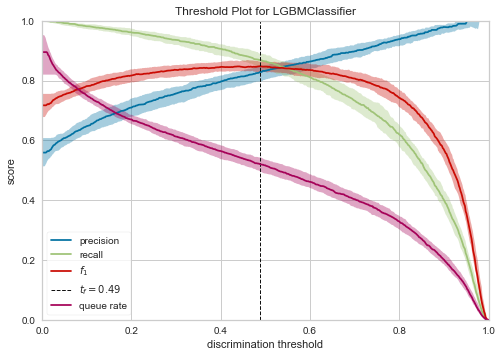

In [91]:
telecom_churn_prediction(lightgbm_, X_train_os, X_test, y_train_os.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = True)

In [92]:
from xgboost import XGBClassifier

In [93]:
model = XGBClassifier()
search = RandomizedSearchCV(model, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_train_os, y_train_os.values.ravel())
search.best_score_, search.best_params_

(0.8416690410750316,
 {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1})

In [94]:
xgboost_ = XGBClassifier(**search.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1282
           1       0.56      0.60      0.58       479

    accuracy                           0.77      1761
   macro avg       0.71      0.71      0.71      1761
weighted avg       0.77      0.77      0.77      1761

Accuracy   Score :  0.7654741624077229
Area under curve :  0.713389015

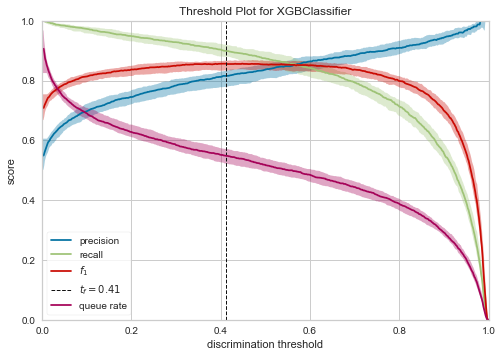

In [95]:
telecom_churn_prediction(xgboost_, X_train_os, X_test, y_train_os.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = True)

Теперь воспользуемся инструментами для отбора фичей и построим модель с отобранными фичами.

In [98]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif

In [99]:
skb = SelectKBest(f_classif, k=10)
X_skb = skb.fit_transform(X, Y.values.ravel())
list_param_skb = np.where(skb.get_support())[0]
list_param_skb

array([ 0, 13, 15, 18, 21, 24, 33, 35, 38, 42], dtype=int64)

In [100]:
sp = SelectPercentile(f_classif)
X_sp = sp.fit_transform(X, Y.values.ravel())
list_param_sp = np.where(sp.get_support())[0]
list_param_sp

array([ 0, 15, 24, 33, 42], dtype=int64)

In [101]:
result_list = list(set((*list_param_skb, *list_param_sp)))
result_list

[0, 33, 35, 38, 42, 13, 15, 18, 21, 24]

In [106]:
X_selected = X_train_os.values[:, result_list]

In [108]:
model = GradientBoostingClassifier(random_state=42)
param_grid = {'learning_rate': [0.1, 0.01, 0.005, 0.001], 'n_estimators': [100, 300, 500, 1000], 'max_depth': [3, 5, 9, 12],
             'max_features': [None, 'sqrt']}

search = RandomizedSearchCV(model, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_selected, y_train_os.values.ravel())
search.best_score_, search.best_params_

(0.8025724996034921,
 {'n_estimators': 500,
  'max_features': 'sqrt',
  'max_depth': 12,
  'learning_rate': 0.005})

In [109]:
GBClassifier_selected = GradientBoostingClassifier(**search.best_params_)

In [113]:
X_test_selected = X_test.values[:, result_list]

In [115]:
telecom_churn_prediction(GBClassifier_selected, X_selected, X_test_selected, y_train_os.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = False)

GradientBoostingClassifier(learning_rate=0.005, max_depth=12,
                           max_features='sqrt', n_estimators=500)

 Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.75      0.81      1282
           1       0.51      0.71      0.59       479

    accuracy                           0.74      1761
   macro avg       0.69      0.73      0.70      1761
weighted avg       0.77      0.74      0.75      1761

Accuracy   Score :  0.7365133446905168
Area under curve :  0.7268433326059557 



In [116]:
param_grid = {'learning_rate': [0.1, 0.01, 0.005, 0.001], 'n_estimators': [100, 300, 500, 1000], 'max_depth': [-1, 3, 5, 9, 12]}

In [117]:
lightgbm_ = LGBMClassifier()
search = RandomizedSearchCV(lightgbm_, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_selected, y_train_os.values.ravel())
search.best_score_, search.best_params_

(0.7936691771654265,
 {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.01})

In [118]:
lightgbm_selected = LGBMClassifier(**search.best_params_)

LGBMClassifier(learning_rate=0.01, max_depth=12, n_estimators=1000)

 Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      1282
           1       0.54      0.73      0.62       479

    accuracy                           0.76      1761
   macro avg       0.71      0.75      0.72      1761
weighted avg       0.79      0.76      0.77      1761

Accuracy   Score :  0.75809199318569
Area under curve :  0.7482021827845974 



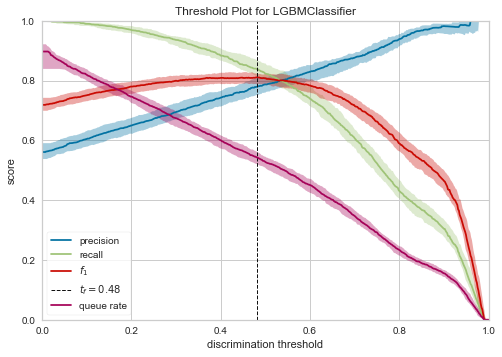

In [119]:
telecom_churn_prediction(lightgbm_selected, X_selected, X_test_selected, y_train_os.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = True)

In [120]:
model = XGBClassifier()
search = RandomizedSearchCV(model, param_grid, scoring='f1', n_iter=40, n_jobs=-1, random_state=42)
search.fit(X_selected, y_train_os.values.ravel())
search.best_score_, search.best_params_

(0.7932875666654718,
 {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1})

In [121]:
xgboost_selected = XGBClassifier(**search.best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1282
           1       0.53      0.67      0.60       479

    accuracy                           0.75      1761
   macro avg       0.70      0.73      0.71      1761
weighted avg       0.77      0.75      0.76      1761

Accuracy   Score :  0.7518455423055083
Area under curve :  0.726912542

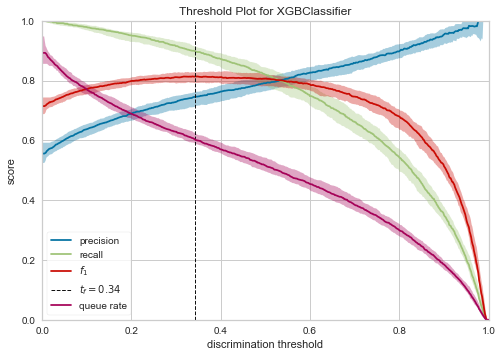

In [122]:
telecom_churn_prediction(xgboost_selected, X_selected, X_test_selected, y_train_os.values.ravel(), y_test.values.ravel(),
                         cols,'features', threshold_plot = True)

In [124]:
from sklearn.metrics import precision_score, recall_score

In [125]:
def model_report(model, X_train, X_test, y_train, y_test, trashold, name):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    result = []
    for value in y_pred_proba[:, 1]:
        if value > trashold:
            result.append(1)
        else:
            result.append(0)
    f1_score_ = f1_score(y_test, result)
    precision = precision_score(y_test, result)
    recall = recall_score(y_test, result)
    accuracy = accuracy_score(y_test, result)
    roc_auc = roc_auc_score(y_test, result)
    df = pd.DataFrame({'Model': [name],
                      'Accuracy score': [accuracy],
                      'F1 score': [f1_score_],
                      'Precision': [precision],
                      'Recall': [recall],
                      'ROC AUC Score': [roc_auc]})
    return df

In [132]:
model_list = [GBclassifier_base, GBclassifier, lightgbm_, xgboost_, GBClassifier_selected, lightgbm_selected, xgboost_selected]

model1 = model_report(GBclassifier_base, X_train, X_test, y_train.values.ravel(), y_test.values.ravel(), 0.24, 'GBClassifier(base)')
model2 = model_report(GBclassifier, X_train_os, X_test, y_train_os.values.ravel(), y_test.values.ravel(), 0.5, 'GBClassifier(SMOTE)')
model3 = model_report(lightgbm_, X_train_os, X_test, y_train_os.values.ravel(), y_test.values.ravel(), 0.49, 'LightGBM(SMOTE)')
model4 = model_report(xgboost_, X_train_os, X_test, y_train_os.values.ravel(), y_test.values.ravel(), 0.41, 'XGBoost(SMOTE)')
model5 = model_report(GBClassifier_selected, X_selected, X_test_selected, y_train_os.values.ravel(), y_test.values.ravel(), 0.5, 'GBClassifier(selected features)')
model6 = model_report(lightgbm_selected, X_selected, X_test_selected, y_train_os.values.ravel(), y_test.values.ravel(), 0.48, 'LightGBM(selected features)')
model7 = model_report(xgboost_selected, X_selected, X_test_selected, y_train_os.values.ravel(), y_test.values.ravel(), 0.34, 'XGBoost(selected features)')

result = pd.concat([model1, model2, model3, model4, model5, model6, model7], axis=0).reset_index()
result = result.drop(columns='index', axis=1)

In [133]:
result.head(7)

,Model,Accuracy score,F1 score,Precision,Recall,ROC AUC Score
0,GBClassifier(base),0.749006,0.650316,0.523567,0.858038,0.783153
1,GBClassifier(SMOTE),0.765474,0.557342,0.572687,0.542797,0.695736
2,LightGBM(SMOTE),0.782510,0.630665,0.586022,0.682672,0.751243
3,XGBoost(SMOTE),0.758660,0.602432,0.545763,0.672234,0.731593
4,GBClassifier(selected features),0.738785,0.594356,0.514504,0.703549,0.727750
5,LightGBM(selected features),0.753549,0.621951,0.533632,0.745303,0.750966
6,XGBoost(selected features),0.707553,0.598597,0.477612,0.801670,0.737029


Лучше всех, на удивление, справилась базовая модель градиентного бустинга, на втором месте оказалась LightGBM(SMOTE). Модельки, которые обучались на датасете с выбранными фичами немного проигрывают своим аналогам, которые обучались на полной выборке. Возможно 10 фичей для выбора окзалось недостаточно, чтобы достичь того же результата. Смысл в отборе признаков возникает тогда, когда фичей очень много и хочется сорктатить время обучения модели. Мы не сильно теряем в качестве, но зато сильно выигрываем по времени.